<br>

<font size=5>**Análise e Ciência de Dados - custo de plano de saúde por pessoa (parte 1)**</font>

---
---

In [1]:
from platform import platform, python_version
print('Platform:', platform())
print('Python version:', python_version())

Platform: Linux-6.1.85+-x86_64-with-glibc2.35
Python version: 3.10.12


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     cross_val_score,
                                     cross_val_predict,
                                     KFold,
                                     StratifiedKFold)

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor

from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

warnings.filterwarnings('ignore')
plt.style.use(style='ggplot')
%matplotlib inline

In [3]:
df = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/FGalvao77/datasets/main/insurance.csv')
df.shape

(1338, 7)

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# var_cat = ['sex', 'smoker', 'region']
# var_num = ['age', 'bmi', 'children']

In [7]:
# categorical_df = df[var_cat]
# numerical_df = df[var_num]

In [8]:
cat_vars = df.select_dtypes(include=['object']).columns
cat_vars

Index(['sex', 'smoker', 'region'], dtype='object')

In [9]:
df2 = df.copy()
df2[cat_vars] = df2[cat_vars].astype('category')

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   expenses  1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


In [10]:
df2.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [11]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.000,64.00
bmi,1338.0,30.665471,6.098382,16.00,26.3000,30.40,34.700,53.10
children,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.000,5.00
expenses,1338.0,13270.422414,12110.011240,1121.87,4740.2875,9382.03,16639.915,63770.43


In [12]:
df2.describe(include='category').T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [13]:
df2.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [14]:
df2.duplicated().sum()

1

In [15]:
df2.drop_duplicates(inplace=True)

In [16]:
df2.duplicated().sum()

0

In [17]:
df2.shape

(1337, 7)

In [18]:
num_vars = df2.select_dtypes(include=['int64', 'float64']).columns
num_vars

Index(['age', 'bmi', 'children', 'expenses'], dtype='object')

In [19]:
df2[num_vars].corr()

,age,bmi,children,expenses
age,1.000000,0.109414,0.041536,0.298308
bmi,0.109414,1.000000,0.012641,0.198637
children,0.041536,0.012641,1.000000,0.067389
expenses,0.298308,0.198637,0.067389,1.000000


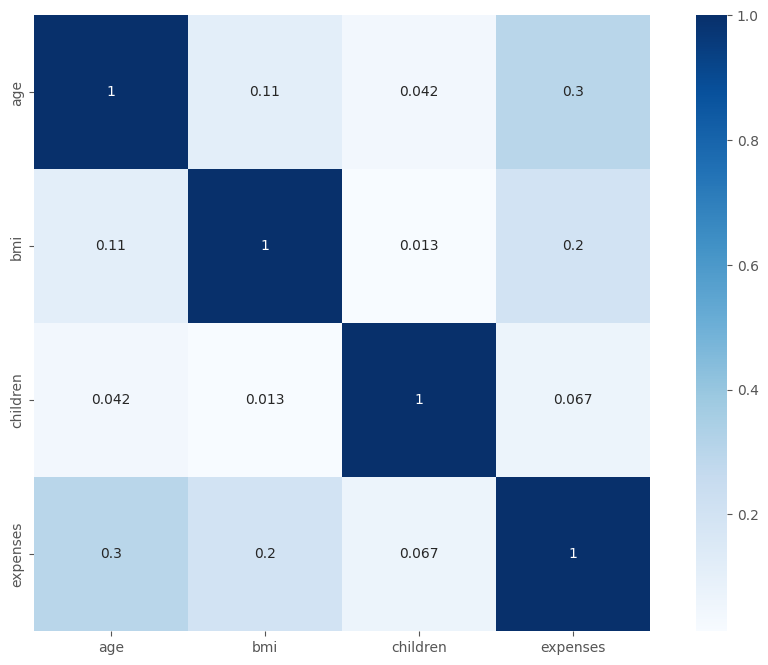

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(df2[num_vars].corr(), annot=True, cmap='Blues', square=True)
plt.show()

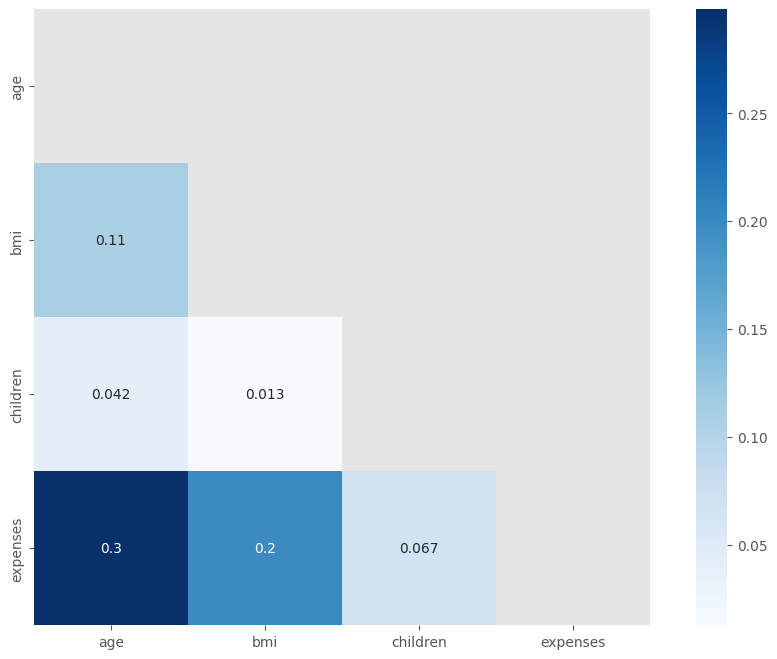

In [21]:
# selecionando apenas a parte triangular inferior da matriz de correlação
mask = np.triu(np.ones_like(df2[num_vars].corr(), dtype=bool))

# plotando o heatmap com a máscara
# plt.style.use(style='default')
plt.figure(figsize=(12, 8))
sns.heatmap(df2[num_vars].corr(), annot=True, cmap='Blues', square=True, mask=mask)
plt.grid(False)
plt.show()

In [22]:
pd.get_dummies(data=df2, drop_first=False, dtype=int).head()

,age,bmi,children,expenses,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,1,0,0,1,0,0,0,1
1,18,33.8,1,1725.55,0,1,1,0,0,0,1,0
2,28,33.0,3,4449.46,0,1,1,0,0,0,1,0
3,33,22.7,0,21984.47,0,1,1,0,0,1,0,0
4,32,28.9,0,3866.86,0,1,1,0,0,1,0,0


In [23]:
df3 = pd.get_dummies(data=df2, drop_first=True, dtype=int)
df3.head()

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,0,1,0,0,1
1,18,33.8,1,1725.55,1,0,0,1,0
2,28,33.0,3,4449.46,1,0,0,1,0
3,33,22.7,0,21984.47,1,0,1,0,0
4,32,28.9,0,3866.86,1,0,1,0,0


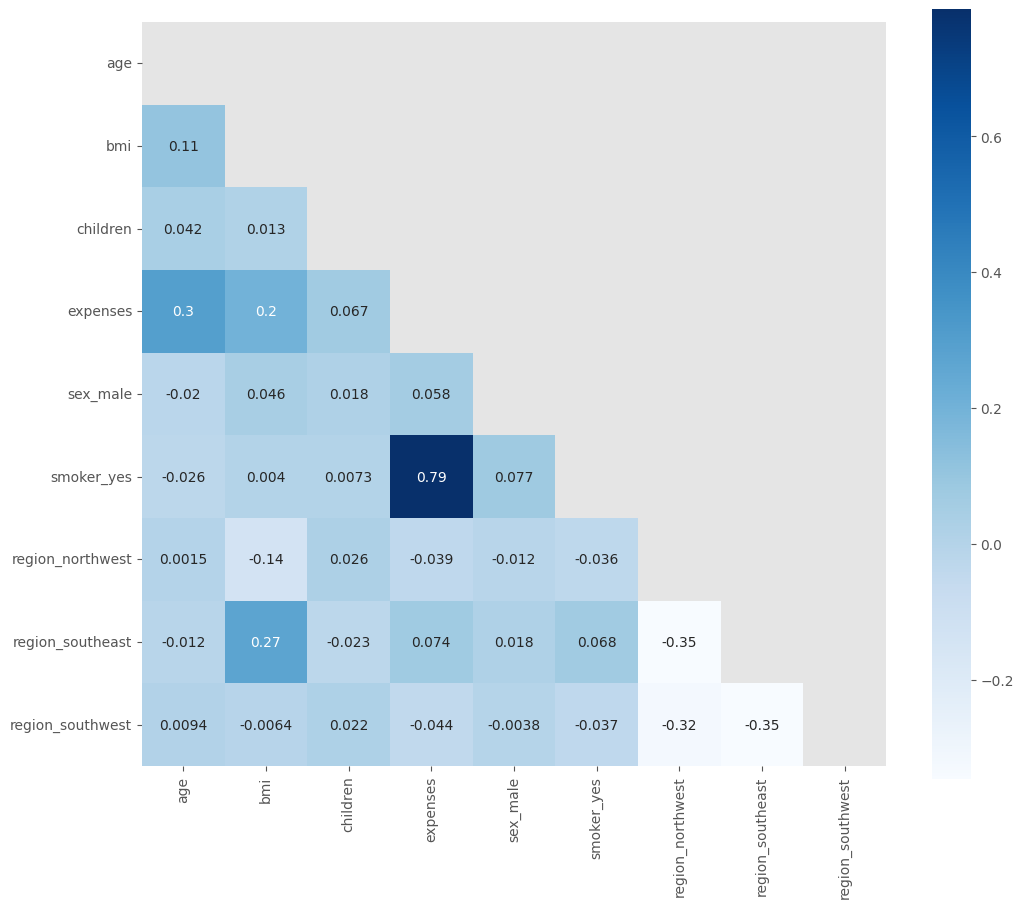

In [24]:
# selecionando apenas a parte triangular inferior da matriz de correlação
mask = np.triu(np.ones_like(df3.corr(), dtype=bool))

# plotando o heatmap com a máscara
plt.figure(figsize=(12, 10))
sns.heatmap(df3.corr(), annot=True, cmap='Blues', square=True, mask=mask)
plt.grid(False)
plt.show()

In [25]:
df3.corr()

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109414,0.041536,0.298308,-0.019814,-0.025587,0.001495,-0.012311,0.009415
bmi,0.109414,1.000000,0.012641,0.198637,0.046405,0.003964,-0.136137,0.270177,-0.006403
children,0.041536,0.012641,1.000000,0.067389,0.017848,0.007331,0.026044,-0.023492,0.021538
expenses,0.298308,0.198637,0.067389,1.000000,0.058045,0.787234,-0.038695,0.073578,-0.043637
sex_male,-0.019814,0.046405,0.017848,0.058045,1.000000,0.076596,-0.012482,0.017578,-0.003767
smoker_yes,-0.025587,0.003964,0.007331,0.787234,0.076596,1.000000,-0.036321,0.068282,-0.037168
region_northwest,0.001495,-0.136137,0.026044,-0.038695,-0.012482,-0.036321,1.000000,-0.345909,-0.320493
region_southeast,-0.012311,0.270177,-0.023492,0.073578,0.017578,0.068282,-0.345909,1.000000,-0.346614
region_southwest,0.009415,-0.006403,0.021538,-0.043637,-0.003767,-0.037168,-0.320493,-0.346614,1.000000


In [26]:
# colorir a correlação das colunas
def color_negative_red(val):
    color = 'red' if val < 0 else 'blue'
    return 'color: %s' % color

styled_corr = df3.corr().style.applymap(color_negative_red)
styled_corr

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109414,0.041536,0.298308,-0.019814,-0.025587,0.001495,-0.012311,0.009415
bmi,0.109414,1.000000,0.012641,0.198637,0.046405,0.003964,-0.136137,0.270177,-0.006403
children,0.041536,0.012641,1.000000,0.067389,0.017848,0.007331,0.026044,-0.023492,0.021538
expenses,0.298308,0.198637,0.067389,1.000000,0.058045,0.787234,-0.038695,0.073578,-0.043637
sex_male,-0.019814,0.046405,0.017848,0.058045,1.000000,0.076596,-0.012482,0.017578,-0.003767
smoker_yes,-0.025587,0.003964,0.007331,0.787234,0.076596,1.000000,-0.036321,0.068282,-0.037168
region_northwest,0.001495,-0.136137,0.026044,-0.038695,-0.012482,-0.036321,1.000000,-0.345909,-0.320493
region_southeast,-0.012311,0.270177,-0.023492,0.073578,0.017578,0.068282,-0.345909,1.000000,-0.346614
region_southwest,0.009415,-0.006403,0.021538,-0.043637,-0.003767,-0.037168,-0.320493,-0.346614,1.000000


In [27]:
df3.corr().style.background_gradient(cmap='coolwarm')

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109414,0.041536,0.298308,-0.019814,-0.025587,0.001495,-0.012311,0.009415
bmi,0.109414,1.000000,0.012641,0.198637,0.046405,0.003964,-0.136137,0.270177,-0.006403
children,0.041536,0.012641,1.000000,0.067389,0.017848,0.007331,0.026044,-0.023492,0.021538
expenses,0.298308,0.198637,0.067389,1.000000,0.058045,0.787234,-0.038695,0.073578,-0.043637
sex_male,-0.019814,0.046405,0.017848,0.058045,1.000000,0.076596,-0.012482,0.017578,-0.003767
smoker_yes,-0.025587,0.003964,0.007331,0.787234,0.076596,1.000000,-0.036321,0.068282,-0.037168
region_northwest,0.001495,-0.136137,0.026044,-0.038695,-0.012482,-0.036321,1.000000,-0.345909,-0.320493
region_southeast,-0.012311,0.270177,-0.023492,0.073578,0.017578,0.068282,-0.345909,1.000000,-0.346614
region_southwest,0.009415,-0.006403,0.021538,-0.043637,-0.003767,-0.037168,-0.320493,-0.346614,1.000000


In [28]:
df3.corr()['expenses'].sort_values(ascending=False)

expenses            1.000000
smoker_yes          0.787234
age                 0.298308
bmi                 0.198637
region_southeast    0.073578
children            0.067389
sex_male            0.058045
region_northwest   -0.038695
region_southwest   -0.043637
Name: expenses, dtype: float64

In [29]:
df3.corr()['expenses'].sort_values(ascending=False) * 100

expenses            100.000000
smoker_yes           78.723437
age                  29.830821
bmi                  19.863713
region_southeast      7.357793
children              6.738935
sex_male              5.804450
region_northwest     -3.869465
region_southwest     -4.363735
Name: expenses, dtype: float64

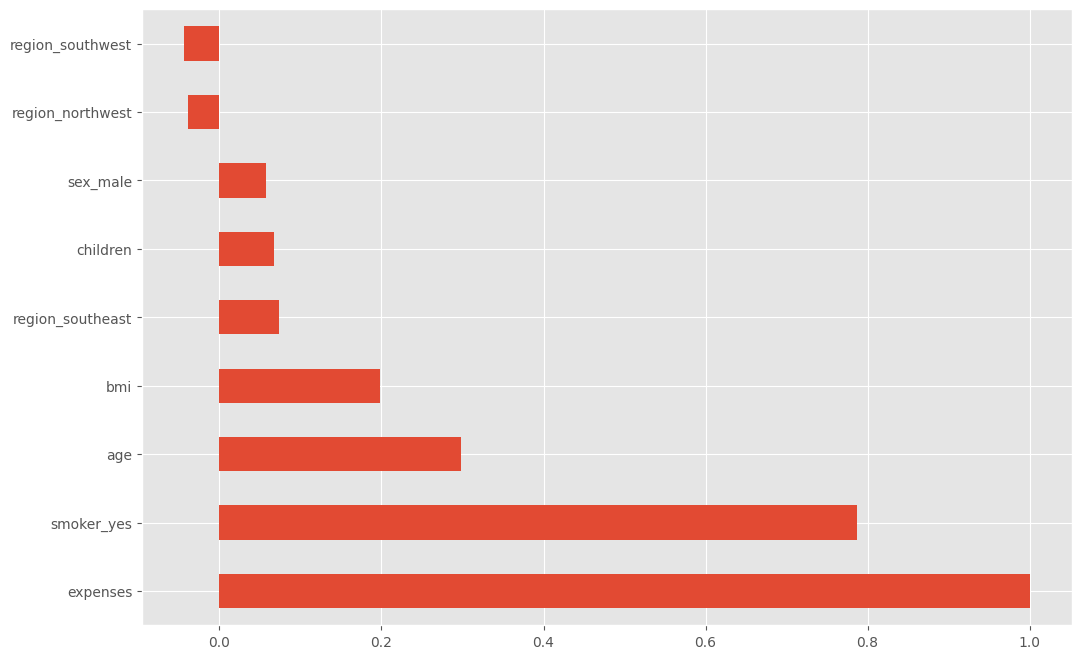

In [30]:
df3.corr()['expenses'].sort_values(ascending=False).plot(kind='barh',
                                                         figsize=(12, 8))
plt.show()

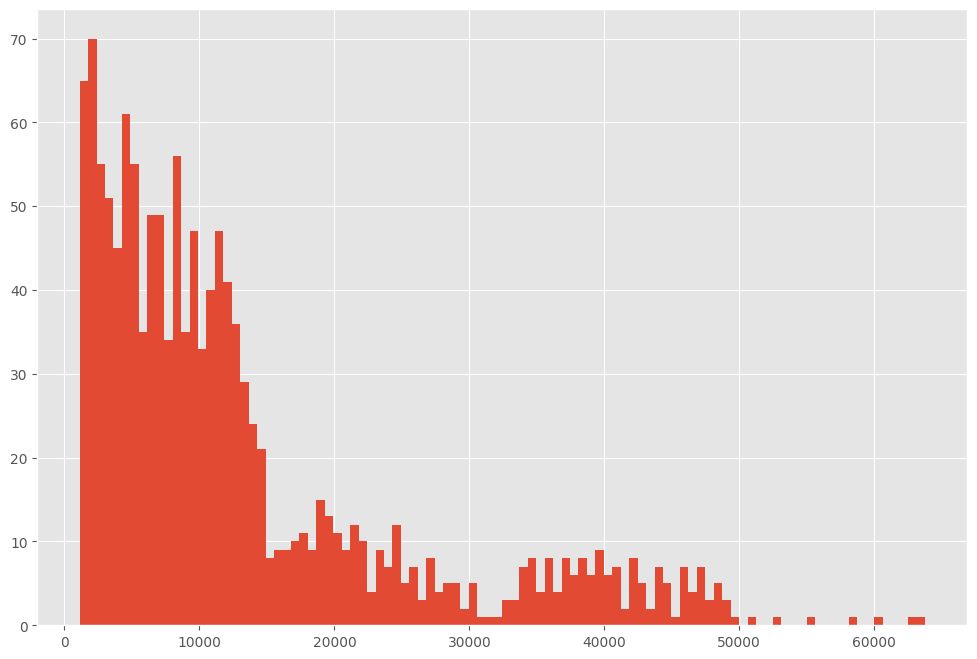

In [31]:
df3['expenses'].hist(bins=100, figsize=(12, 8))
plt.show()

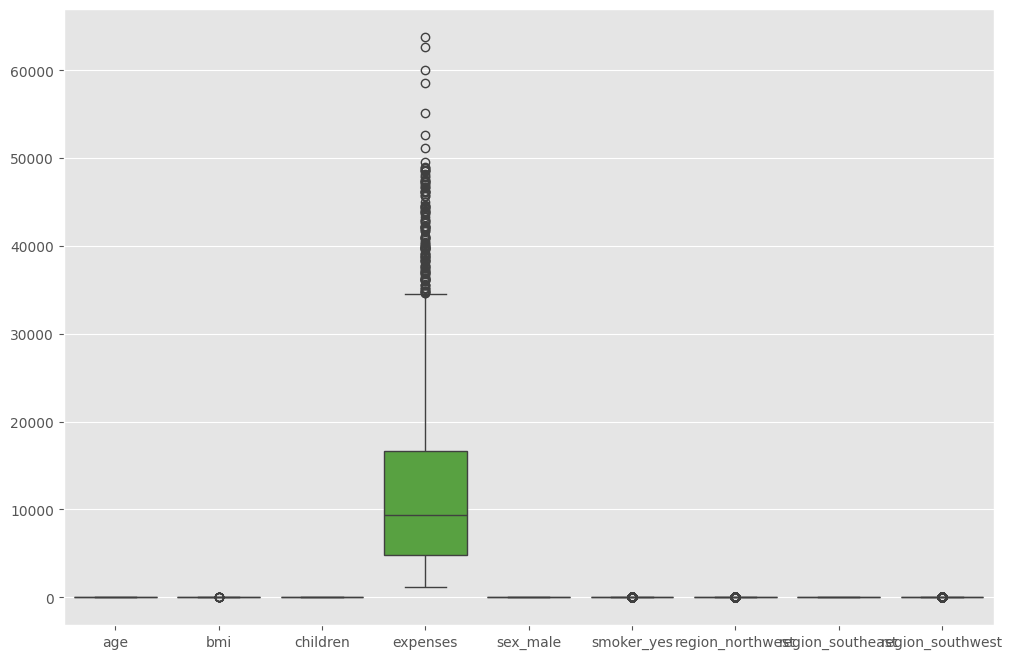

In [35]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df3)
plt.show()

In [39]:
df3.columns

Index(['age', 'bmi', 'children', 'expenses', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [41]:
cols = df3.columns.tolist()[:4]
cols

['age', 'bmi', 'children', 'expenses']

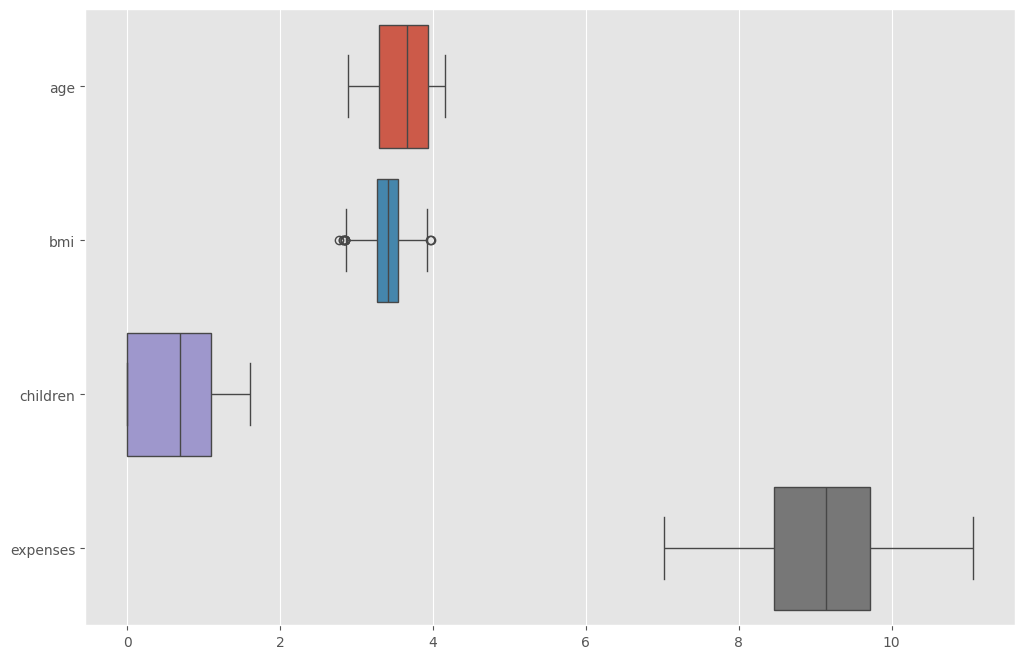

In [44]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=np.log(df3[cols]), orient='h')
plt.show()

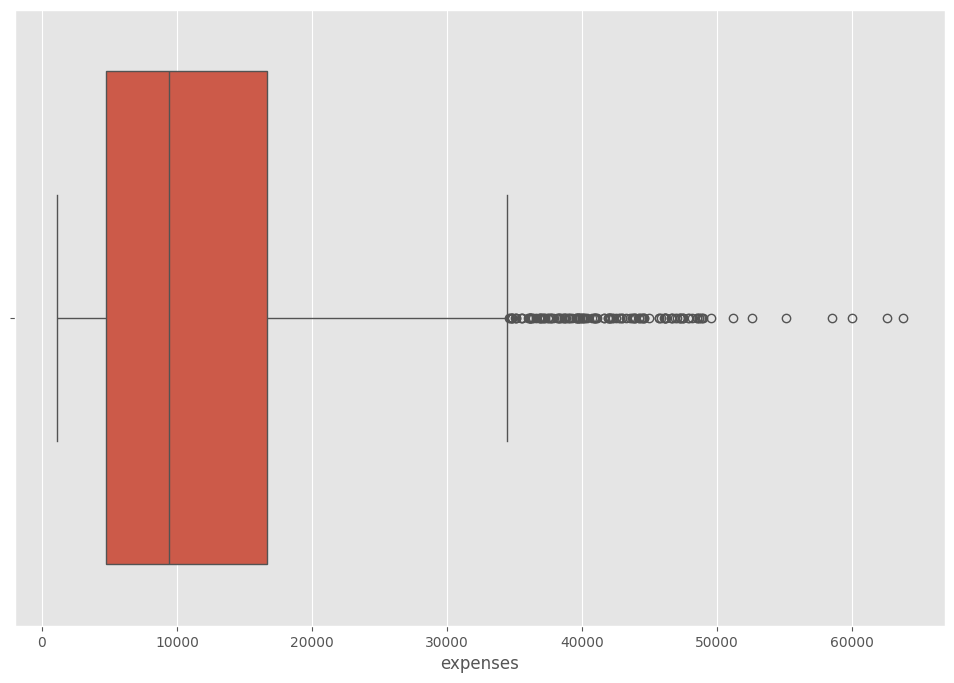

In [45]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df3, x='expenses')
plt.show()

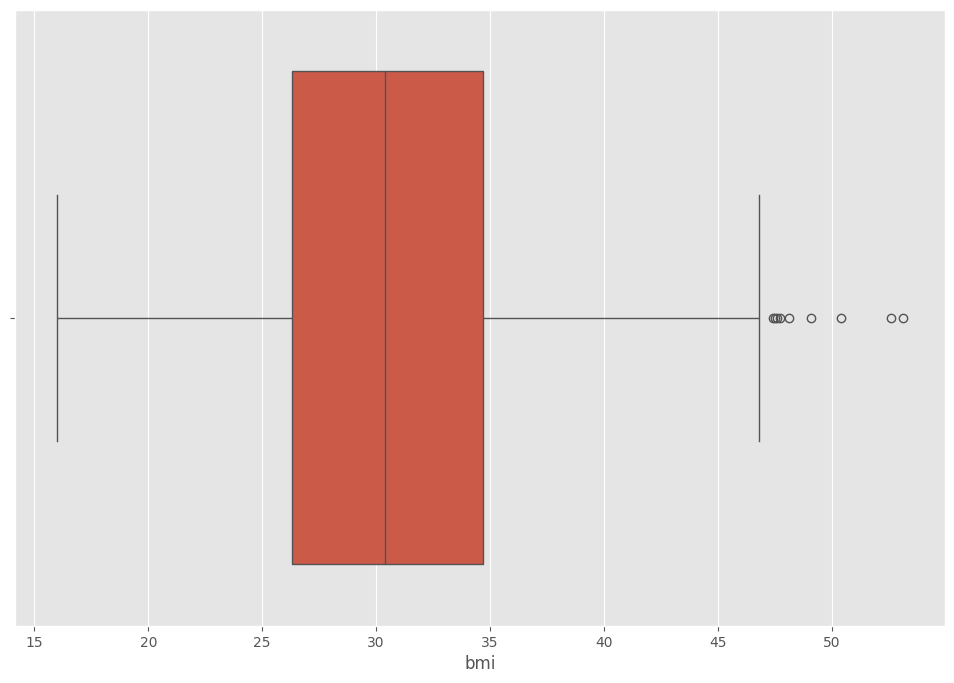

In [46]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df3, x='bmi')
plt.show()

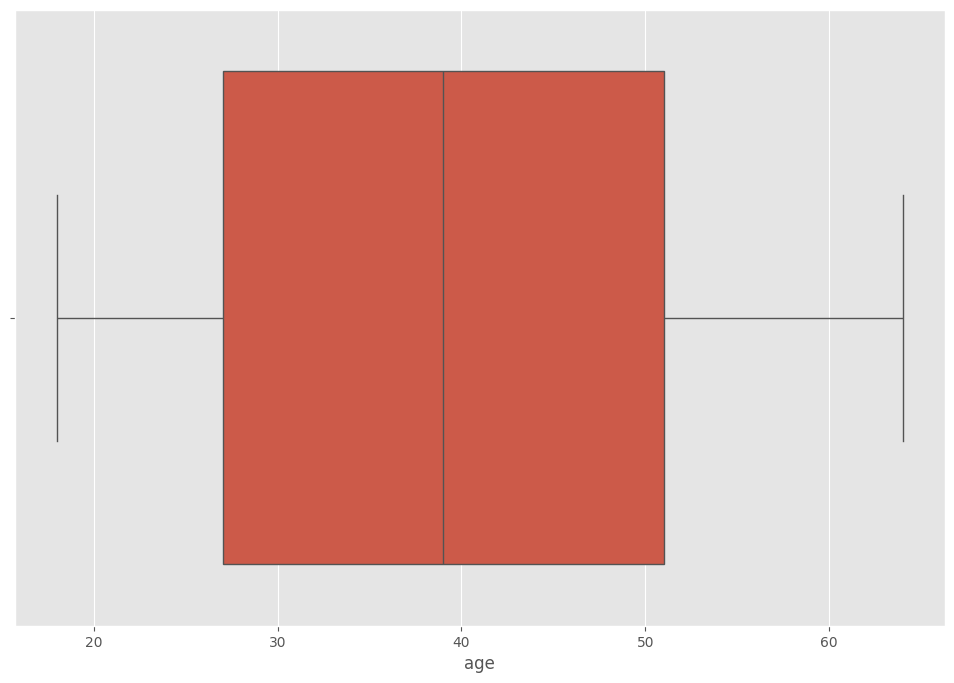

In [50]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df3, x='age')
plt.show()

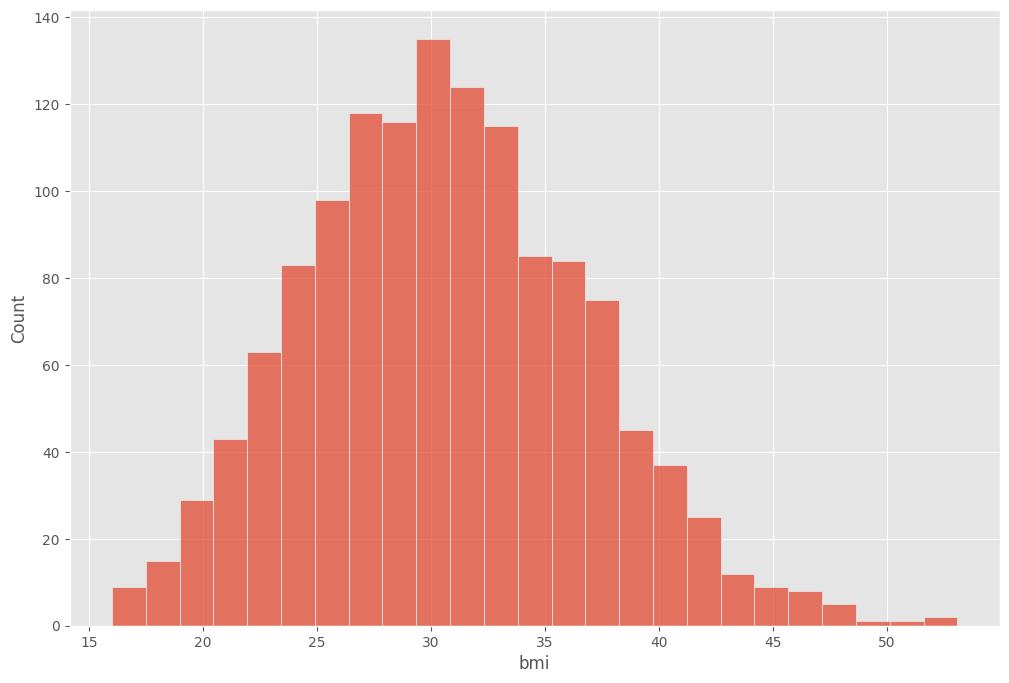

In [53]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df3, x='bmi')
plt.show()

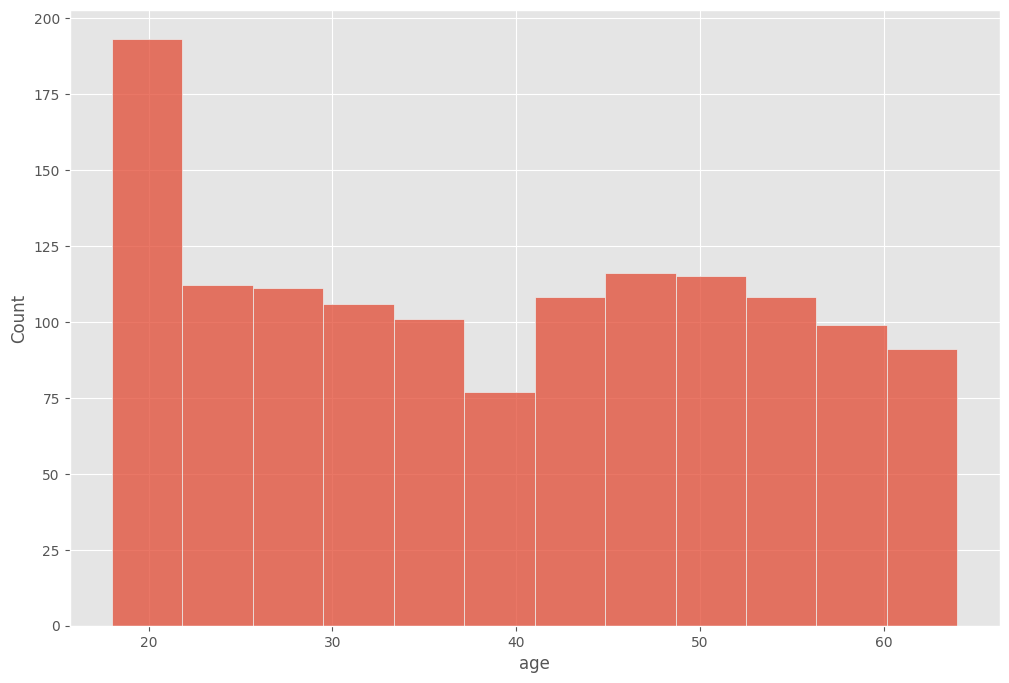

In [54]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df3, x='age')
plt.show()

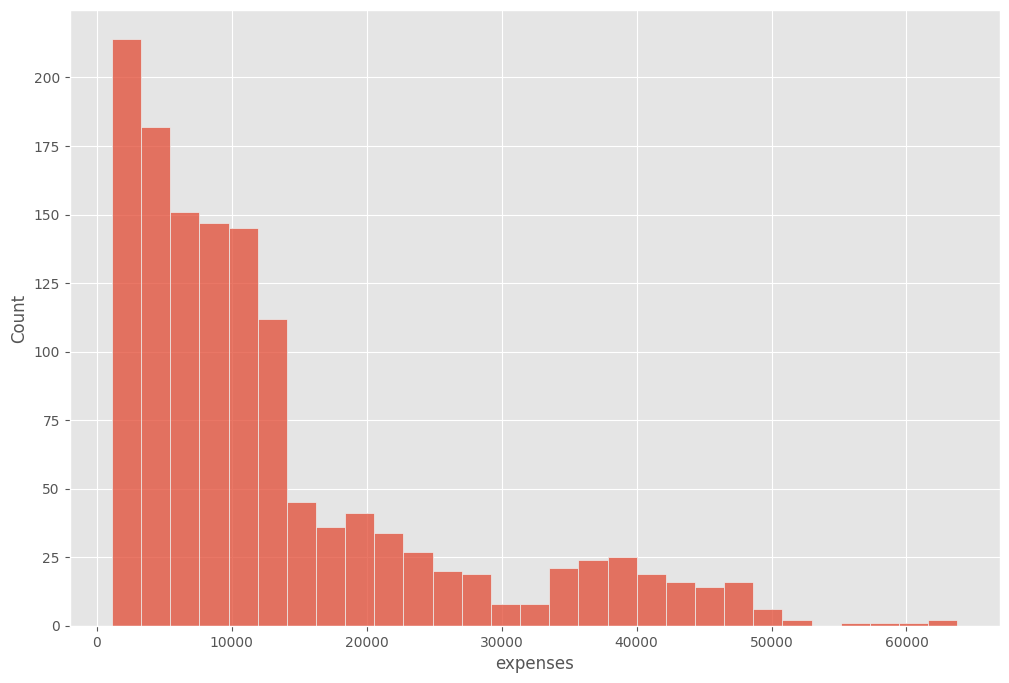

In [55]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df3, x='expenses')
plt.show()

In [47]:
X = df3.drop(columns=['expenses'])
y = df3['expenses']

In [48]:
X.shape, y.shape

((1337, 8), (1337,))

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [56]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1069, 8), (268, 8), (1069,), (268,))

In [57]:
pd.DataFrame(X_train).describe().T

,count,mean,std,min,25%,50%,75%,max
age,1069.0,39.198316,13.998594,18.0,27.0,39.0,51.0,64.0
bmi,1069.0,30.542470,6.051032,16.0,26.2,30.2,34.4,53.1
children,1069.0,1.084191,1.194723,0.0,0.0,1.0,2.0,5.0
sex_male,1069.0,0.514500,0.500024,0.0,0.0,1.0,1.0,1.0
smoker_yes,1069.0,0.200187,0.400328,0.0,0.0,0.0,0.0,1.0
region_northwest,1069.0,0.246960,0.431445,0.0,0.0,0.0,0.0,1.0
region_southeast,1069.0,0.268475,0.443374,0.0,0.0,0.0,1.0,1.0
region_southwest,1069.0,0.247895,0.431993,0.0,0.0,0.0,0.0,1.0


In [58]:
pd.DataFrame(X_test).describe().T

,count,mean,std,min,25%,50%,75%,max
age,268.0,39.317164,14.251361,18.0,25.750,40.0,51.000,64.0
bmi,268.0,31.156343,6.282315,16.8,26.775,31.1,35.225,48.1
children,268.0,1.141791,1.249137,0.0,0.000,1.0,2.000,5.0
sex_male,268.0,0.466418,0.499804,0.0,0.000,0.0,1.000,1.0
smoker_yes,268.0,0.223881,0.417623,0.0,0.000,0.0,0.000,1.0
region_northwest,268.0,0.223881,0.417623,0.0,0.000,0.0,0.000,1.0
region_southeast,268.0,0.287313,0.453356,0.0,0.000,0.0,1.000,1.0
region_southwest,268.0,0.223881,0.417623,0.0,0.000,0.0,0.000,1.0


In [59]:
scal = StandardScaler()
X_train_scaled = scal.fit_transform(X_train)
X_test_scaled = scal.transform(X_test)

In [60]:
pd.DataFrame(X_train_scaled).describe().T

,count,mean,std,min,25%,50%,75%,max
0,1069.0,1.678317e-16,1.000468,-1.515026,-0.871804,-0.014173,0.843457,1.772556
1,1069.0,-2.741804e-16,1.000468,-2.404429,-0.717977,-0.056623,0.637798,3.729626
2,1069.0,5.068184e-17,1.000468,-0.907908,-0.907908,-0.070502,0.766904,3.279123
3,1069.0,4.154249e-17,1.000468,-1.029432,-1.029432,0.971409,0.971409,0.971409
4,1069.0,3.489569e-17,1.000468,-0.500292,-0.500292,-0.500292,-0.500292,1.998831
5,1069.0,-7.311478e-17,1.000468,-0.572669,-0.572669,-0.572669,-0.572669,1.746208
6,1069.0,1.661700e-18,1.000468,-0.605812,-0.605812,-0.605812,1.650678,1.650678
7,1069.0,2.658719e-17,1.000468,-0.574110,-0.574110,-0.574110,-0.574110,1.741827


In [61]:
pd.DataFrame(X_test_scaled).describe().T

,count,mean,std,min,25%,50%,75%,max
0,268.0,0.008494,1.018533,-1.515026,-0.961140,0.057296,0.843457,1.772556
1,268.0,0.101497,1.038708,-2.272158,-0.622907,0.092181,0.774202,2.902934
2,268.0,0.048235,1.046035,-0.907908,-0.907908,-0.070502,0.766904,3.279123
3,268.0,-0.096204,1.000029,-1.029432,-1.029432,-1.029432,0.971409,0.971409
4,268.0,0.059213,1.043691,-0.500292,-0.500292,-0.500292,-0.500292,1.998831
5,268.0,-0.053518,0.968416,-0.572669,-0.572669,-0.572669,-0.572669,1.746208
6,268.0,0.042508,1.022992,-0.605812,-0.605812,-0.605812,1.650678,1.650678
7,268.0,-0.055616,0.967188,-0.574110,-0.574110,-0.574110,-0.574110,1.741827


In [62]:
models = [
    LinearRegression(n_jobs=-1),
    Ridge(random_state=42),
    Lasso(random_state=42),
    ElasticNet(random_state=42),
    KNeighborsRegressor(n_jobs=-1),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(n_jobs=-1, random_state=42),
    GradientBoostingRegressor(random_state=42),
    MLPRegressor(random_state=42),
    XGBRegressor(n_jobs=-1, random_state=42)
    ]

models

[LinearRegression(n_jobs=-1),
 Ridge(random_state=42),
 Lasso(random_state=42),
 ElasticNet(random_state=42),
 KNeighborsRegressor(n_jobs=-1),
 DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(n_jobs=-1, random_state=42),
 GradientBoostingRegressor(random_state=42),
 MLPRegressor(random_state=42),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jo

In [63]:
results = {}
for model in models:
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled).round(2)
  r2 = r2_score(y_test, y_pred).round(2)
  mae = mean_absolute_error(y_test, y_pred).round(2)
  mse = mean_squared_error(y_test, y_pred).round(2)
  rmse = np.sqrt(mse).round(2)
  results[model.__class__.__name__] = [r2, mae, mse, rmse]

pd.DataFrame(results, index=['R2', 'MAE', 'MSE', 'RMSE'])

,LinearRegression,Ridge,Lasso,ElasticNet,KNeighborsRegressor,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor
R2,0.81,0.81,0.81,0.67,0.84,0.79,0.88,0.90,-1.000000e+00,0.86
MAE,4177.27,4179.84,4177.44,5522.83,3471.93,2916.99,2664.86,2534.76,1.380336e+04,2906.60
MSE,35481467.94,35515901.62,35488799.61,60621578.13,29900870.97,38918076.01,22227852.66,18384662.61,3.670410e+08,25969907.13
RMSE,5956.63,5959.52,5957.25,7785.99,5468.17,6238.44,4714.64,4287.73,1.915831e+04,5096.07


In [64]:
models_dict = {
    'LinearRegression': LinearRegression(n_jobs=-1),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'DecionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'KNeighborsRegressor': KNeighborsRegressor(n_jobs=-1),
    'RandomForestRegressor': RandomForestRegressor(n_jobs=-1, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'MLPRegressor': MLPRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(n_jobs=-1, random_state=42)
}

models_dict

{'LinearRegression': LinearRegression(n_jobs=-1),
 'Ridge': Ridge(random_state=42),
 'Lasso': Lasso(random_state=42),
 'ElasticNet': ElasticNet(random_state=42),
 'DecionTreeRegressor': DecisionTreeRegressor(random_state=42),
 'KNeighborsRegressor': KNeighborsRegressor(n_jobs=-1),
 'RandomForestRegressor': RandomForestRegressor(n_jobs=-1, random_state=42),
 'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
 'MLPRegressor': MLPRegressor(random_state=42),
 'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_d

In [101]:
results2 = {}
for name, model in models_dict.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred).round(2)
    mae = mean_absolute_error(y_test, y_pred).round(2)
    mse = mean_squared_error(y_test, y_pred).round(2)
    rmse = np.sqrt(mse).round(2)
    results2[name] = [r2, mae, mse, rmse]

pd.DataFrame(results, index=['R2', 'MAE', 'MSE', 'RMSE'])

,LinearRegression,Ridge,Lasso,ElasticNet,KNeighborsRegressor,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor
R2,0.81,0.81,0.81,0.67,0.84,0.79,0.88,0.90,-1.000000e+00,0.86
MAE,4177.27,4179.84,4177.44,5522.83,3471.93,2916.99,2664.86,2534.76,1.380336e+04,2906.60
MSE,35481467.94,35515901.62,35488799.61,60621578.13,29900870.97,38918076.01,22227852.66,18384662.61,3.670410e+08,25969907.13
RMSE,5956.63,5959.52,5957.25,7785.99,5468.17,6238.44,4714.64,4287.73,1.915831e+04,5096.07


In [102]:
models_grid = {
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'KNeighborsRegressor': KNeighborsRegressor(n_jobs=-1),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(n_jobs=-1, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'MLPRegressor': MLPRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(n_jobs=-1, random_state=42)
}

models_grid

{'Ridge': Ridge(random_state=42),
 'Lasso': Lasso(random_state=42),
 'ElasticNet': ElasticNet(random_state=42),
 'KNeighborsRegressor': KNeighborsRegressor(n_jobs=-1),
 'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
 'RandomForestRegressor': RandomForestRegressor(n_jobs=-1, random_state=42),
 'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
 'MLPRegressor': MLPRegressor(random_state=42),
 'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,

In [67]:
Ridge.get_params(models_grid['Ridge'])

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': 42,
 'solver': 'auto',
 'tol': 0.0001}

In [68]:
Lasso.get_params(models_grid['Lasso'])

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': 42,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [69]:
ElasticNet.get_params(models_grid['ElasticNet'])

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': 42,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [70]:
DecisionTreeRegressor.get_params(models_grid['DecisionTreeRegressor'])

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [71]:
RandomForestRegressor.get_params(models_grid['RandomForestRegressor'])

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [72]:
GradientBoostingRegressor.get_params(models_grid['GradientBoostingRegressor'])

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [73]:
MLPRegressor.get_params(models_grid['MLPRegressor'])

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [74]:
XGBRegressor.get_params(models_grid['XGBRegressor'])

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [82]:
# importando a biblioteca
import inspect

# importando os modelos
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# dicionário com os modelos
models_ = {
    'ElasticNet': ElasticNet,
    'Lasso': Lasso,
    'Ridge': Ridge ,
    'KNeighborsRegressor': KNeighborsRegressor,
    'DecisionTreeRegressor': DecisionTreeRegressor,
    'RandomForestRegressor': RandomForestRegressor,
    'GradientBoostingRegressor': GradientBoostingRegressor,
    'MLPRegressor': MLPRegressor,
    'XGBRegressor': XGBRegressor
    }

# instanciando assinaturas dos modelos
elasticnet_signature = inspect.signature(models_['ElasticNet'])
lasso_signature = inspect.signature(models_['Lasso'])
ridge_signature = inspect.signature(models_['Ridge'])
kneighbors_signature = inspect.signature(models_['KNeighborsRegressor'])
decisiontree_signature = inspect.signature(models_['DecisionTreeRegressor'])
randomforest_signature = inspect.signature(models_['RandomForestRegressor'])
gradientboosting_signature = inspect.signature(models_['GradientBoostingRegressor'])
mlp_signature = inspect.signature(models_['MLPRegressor'])
xgb_signature = inspect.signature(models_['XGBRegressor'])

for name, model in models_.items():
    signature = inspect.signature(model)
    print(f'Model: {name}')
    print(f'Signature: {signature}')
    print('\n')

# imprimindo as assinaturas dos modelos
# display('ElasticNet signature:', (elasticnet_signature))
# display('Lasso signature:', lasso_signature)
# display('Ridge signature:', ridge_signature)
# display('KNeighborsRegressor signature:', kneighbors_signature)
# display('DecisionTreeRegressor signature:', decisiontree_signature)
# display('RandomForestRegressor signature:', randomforest_signature)
# display('GradientBoostingRegressor signature:', gradientboosting_signature)
# display('MLPRegressor signature:', mlp_signature)
# display('XGBRegressor signature:', xgb_signature)

Model: ElasticNet
Signature: (alpha=1.0, *, l1_ratio=0.5, fit_intercept=True, precompute=False, max_iter=1000, copy_X=True, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')


Model: Lasso
Signature: (alpha=1.0, *, fit_intercept=True, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')


Model: Ridge
Signature: (alpha=1.0, *, fit_intercept=True, copy_X=True, max_iter=None, tol=0.0001, solver='auto', positive=False, random_state=None)


Model: KNeighborsRegressor
Signature: (n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)


Model: DecisionTreeRegressor
Signature: (*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)




In [ ]:
?Ridge

In [ ]:
?Lasso

In [ ]:
?ElasticNet

In [ ]:
?KNeighborsRegressor

In [ ]:
?DecisionTreeRegressor

In [ ]:
?RandomForestRegressor

In [ ]:
?GradientBoostingRegressor

In [ ]:
?MLPRegressor

In [ ]:
?XGBRegressor

In [83]:
param_grid = {
    # elasticnet
    'ElasticNet': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                   'l1_ratio': np.arange(0.0, 1.0, 0.1),
                   'precompute': [True, False],
                   'max_iter': [10, 50, 100, 500],
                   'random_state': np.arange(1, 1_001, 1),
                   'selection': ['cyclic', 'random']},
    # lasso
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'precompute': [True, False],
              'max_iter': [10, 50, 100, 500],
              'random_state': np.arange(1, 1_001, 1)},
    # ridge
    'Ridge': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'max_iter': [10, 50, 100, 500],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                         'sparse_cg', 'sag', 'saga', 'lbfgs'],
              'random_state': np.arange(1, 1_001, 1)},
    # k-neighbors
    'KNeighborsRegressor': {'n_neighbors': np.arange(5, 101, 1),
                            'weights': ['uniform', 'distance'],
                            'algorithm': ['auto', 'ball_tree',
                                          'kd_tree', 'brute'],
                            'leaf_size': np.arange(3, 101, 1),
                            'p': [1, 2],
                            'metric': ['euclidean', 'manhattan', 'minkowski']},
    # decision tree
    'DecisionTreeRegressor': {'criterion': ['squared_error', 'friedman_mse',
                                           'absolute_error', 'poisson'],
                              'splitter': ['best', 'random'],
                              'max_depth': [None, 10, 20, 30, 40, 50],
                              'min_samples_split': [2, 5, 10, 15, 20],
                              'min_samples_leaf': [1, 2, 4, 8, 16],
                              'random_state': np.arange(1, 1_001, 1),
                              'max_features': ['auto', 'sqrt', 'log2']},
    # random forest
    'RandomForestRegressor': {'criterion': ['squared_error', 'friedman_mse',
                                           'absolute_error', 'poisson'],
                              'n_estimators': [10, 50, 100, 500, 1_000],
                              'max_depth': [None, 10, 20, 30, 40, 50],
                              'min_samples_split': [2, 5, 10, 15, 20],
                              'min_samples_leaf': [1, 2, 4, 8, 16],
                              'random_state': np.arange(1, 1_001, 1),
                              'max_features': ['auto', 'sqrt', 'log2']},
    # gradient boosting
    'GradientBoostingRegressor': {'loss': ['squared_error', 'absolute_error',
                                           'huber', 'quantile'],
                                  'learning_rate': [0.001, 0.01, 0.1, 1],
                                  'n_estimators': [10, 50, 100, 500, 1_000],
                                  'max_depth': [None, 10, 20, 30, 40, 50],
                                  'min_samples_split': [2, 5, 10, 15, 20],
                                  'min_samples_leaf': [1, 2, 4, 8, 10],
                                  'random_state': np.arange(1, 1_001, 1),
                                  'max_features': ['auto', 'sqrt', 'log2']},
    # mlp
    'MLPRegressor': {'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                            (100, 50, 100), (100, 100, 100)],
                     'activation': ['identity', 'logistic', 'tanh', 'relu'],
                     'solver': ['lbfgs', 'sgd', 'adam'],
                     'learning_rate': ['constant', 'invscaling', 'adaptive'],
                     'random_state': np.arange(1, 10_000, 1)},
    # xgboost
    'XGBRegressor': {'n_estimators': [10, 50, 100, 500, 1_000],
                     'learning_rate': [0.001, 0.01, 0.1, 1],
                     'max_depth': [None, 10, 20, 30, 40, 50],
                     'min_samples_split': [2, 5, 10, 15, 20],
                     'min_samples_leaf': [1, 2, 4, 8, 16],
                     'random_state': np.arange(1, 1_001, 1),
                     'max_features': ['auto', 'sqrt', 'log2']}
}

# param_grid

In [84]:
best_models = {}
for name, model in models_grid.items():
    random_search = RandomizedSearchCV(model, param_grid[name], cv=10,
                                       scoring='r2')
    random_search.fit(X_train_scaled, y_train)
    best_models[name] = random_search.best_estimator_
    print(f'Model: {name}')
    print(f'Best params: {random_search.best_params_}')
    print(f'Best score: {random_search.best_score_}')
    print('=' * 180)

best_models

Model: Ridge
Best params: {'solver': 'sparse_cg', 'random_state': 764, 'max_iter': 10, 'alpha': 10}
Best score: 0.7229054164453033
Model: Lasso
Best params: {'random_state': 7, 'precompute': False, 'max_iter': 50, 'alpha': 100}
Best score: 0.7232086723816924
Model: ElasticNet
Best params: {'selection': 'random', 'random_state': 140, 'precompute': False, 'max_iter': 500, 'l1_ratio': 0.7000000000000001, 'alpha': 0.01}
Best score: 0.7228109678685432
Model: KNeighborsRegressor
Best params: {'weights': 'distance', 'p': 2, 'n_neighbors': 9, 'metric': 'manhattan', 'leaf_size': 49, 'algorithm': 'auto'}
Best score: 0.7745807677283276
Model: DecisionTreeRegressor
Best params: {'splitter': 'best', 'random_state': 579, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'absolute_error'}
Best score: 0.8351040101441589
Model: RandomForestRegressor
Best params: {'random_state': 969, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 16,

{'Ridge': Ridge(alpha=10, max_iter=10, random_state=764, solver='sparse_cg'),
 'Lasso': Lasso(alpha=100, max_iter=50, random_state=7),
 'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.7000000000000001, max_iter=500,
            random_state=140, selection='random'),
 'KNeighborsRegressor': KNeighborsRegressor(leaf_size=49, metric='manhattan', n_jobs=-1, n_neighbors=9,
                     weights='distance'),
 'DecisionTreeRegressor': DecisionTreeRegressor(criterion='absolute_error', max_depth=20,
                       max_features='auto', min_samples_leaf=8,
                       min_samples_split=10, random_state=579),
 'RandomForestRegressor': RandomForestRegressor(criterion='friedman_mse', max_features='auto',
                       min_samples_leaf=16, min_samples_split=5, n_jobs=-1,
                       random_state=969),
 'GradientBoostingRegressor': GradientBoostingRegressor(loss='huber', max_depth=40, max_features='auto',
                           min_samples_leaf=8, n_es

In [85]:
# best_models = {}
# for name, model in models_grid.items():
#     grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='r2')
#     grid_search.fit(X_train_scaled, y_train)
#     best_models[name] = grid_search.best_estimator_
#     print(f'{name} best params: {grid_search.best_params_}')
#     print(f'{name} best score: {grid_search.best_score_}')
#     print()

# best_models

In [86]:
# best_models = {}
# for name, model in models_grid.items():
#     grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_mean_squared_error')
#     grid_search.fit(X_train_scaled, y_train)
#     best_models[name] = grid_search.best_estimator_
#     print(f'{name} best params: {grid_search.best_params_}')
#     print(f'{name} best score: {grid_search.best_score_}')
#     print()

# best_models

In [87]:
# best_models2 = {}
# for name, model in models_grid.items():
#     random_search = RandomizedSearchCV(model, param_grid[name], cv=10,
#                                        scoring='neg_mean_squared_error')
#     random_search.fit(X_train_scaled, y_train)
#     best_models2[name] = random_search.best_estimator_
#     print(f'{name} best params: {random_search.best_params_}')
#     print(f'{name} best score: {random_search.best_score_}')
#     print()

# best_models2

In [103]:
best_models.keys()

dict_keys(['Ridge', 'Lasso', 'ElasticNet', 'KNeighborsRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor', 'MLPRegressor', 'XGBRegressor'])

In [104]:
best_models.items()

dict_items([('Ridge', Ridge(alpha=10, max_iter=10, random_state=764, solver='sparse_cg')), ('Lasso', Lasso(alpha=100, max_iter=50, random_state=7)), ('ElasticNet', ElasticNet(alpha=0.01, l1_ratio=0.7000000000000001, max_iter=500,
           random_state=140, selection='random')), ('KNeighborsRegressor', KNeighborsRegressor(leaf_size=49, metric='manhattan', n_jobs=-1, n_neighbors=9,
                    weights='distance')), ('DecisionTreeRegressor', DecisionTreeRegressor(criterion='absolute_error', max_depth=20,
                      max_features='auto', min_samples_leaf=8,
                      min_samples_split=10, random_state=579)), ('RandomForestRegressor', RandomForestRegressor(criterion='friedman_mse', max_features='auto',
                      min_samples_leaf=16, min_samples_split=5, n_jobs=-1,
                      random_state=969)), ('GradientBoostingRegressor', GradientBoostingRegressor(loss='huber', max_depth=40, max_features='auto',
                          min_samples_l

In [105]:
# acessando cada item individual do "best_models"
params_dict = {}
for model_name, params in best_models.items():
    print(f'Model: {model_name}')
    print(f'Parameters: {params}')
    params_dict[params] = params
    print('-' * 80)

Model: Ridge
Parameters: Ridge(alpha=10, max_iter=10, random_state=764, solver='sparse_cg')
--------------------------------------------------------------------------------
Model: Lasso
Parameters: Lasso(alpha=100, max_iter=50, random_state=7)
--------------------------------------------------------------------------------
Model: ElasticNet
Parameters: ElasticNet(alpha=0.01, l1_ratio=0.7000000000000001, max_iter=500,
           random_state=140, selection='random')
--------------------------------------------------------------------------------
Model: KNeighborsRegressor
Parameters: KNeighborsRegressor(leaf_size=49, metric='manhattan', n_jobs=-1, n_neighbors=9,
                    weights='distance')
--------------------------------------------------------------------------------
Model: DecisionTreeRegressor
Parameters: DecisionTreeRegressor(criterion='absolute_error', max_depth=20,
                      max_features='auto', min_samples_leaf=8,
                      min_samples_split=1

In [106]:
type(params_dict), len(params_dict)

(dict, 9)

In [107]:
params_dict

{Ridge(alpha=10, max_iter=10, random_state=764, solver='sparse_cg'): Ridge(alpha=10, max_iter=10, random_state=764, solver='sparse_cg'),
 Lasso(alpha=100, max_iter=50, random_state=7): Lasso(alpha=100, max_iter=50, random_state=7),
 ElasticNet(alpha=0.01, l1_ratio=0.7000000000000001, max_iter=500,
            random_state=140, selection='random'): ElasticNet(alpha=0.01, l1_ratio=0.7000000000000001, max_iter=500,
            random_state=140, selection='random'),
 KNeighborsRegressor(leaf_size=49, metric='manhattan', n_jobs=-1, n_neighbors=9,
                     weights='distance'): KNeighborsRegressor(leaf_size=49, metric='manhattan', n_jobs=-1, n_neighbors=9,
                     weights='distance'),
 DecisionTreeRegressor(criterion='absolute_error', max_depth=20,
                       max_features='auto', min_samples_leaf=8,
                       min_samples_split=10, random_state=579): DecisionTreeRegressor(criterion='absolute_error', max_depth=20,
                       max_feat

In [108]:
params_dict.keys()

dict_keys([Ridge(alpha=10, max_iter=10, random_state=764, solver='sparse_cg'), Lasso(alpha=100, max_iter=50, random_state=7), ElasticNet(alpha=0.01, l1_ratio=0.7000000000000001, max_iter=500,
           random_state=140, selection='random'), KNeighborsRegressor(leaf_size=49, metric='manhattan', n_jobs=-1, n_neighbors=9,
                    weights='distance'), DecisionTreeRegressor(criterion='absolute_error', max_depth=20,
                      max_features='auto', min_samples_leaf=8,
                      min_samples_split=10, random_state=579), RandomForestRegressor(criterion='friedman_mse', max_features='auto',
                      min_samples_leaf=16, min_samples_split=5, n_jobs=-1,
                      random_state=969), GradientBoostingRegressor(loss='huber', max_depth=40, max_features='auto',
                          min_samples_leaf=8, n_estimators=50,
                          random_state=530), MLPRegressor(hidden_layer_sizes=(100, 50, 100), learning_rate='adaptive',
     

In [109]:
# acessando cada item individual do "params_dict"
for model, params in params_dict.items():
    print(f'Model: {model}')
    # print(f'Parameters: {params.get_params()}') # Use get_params() to access the parameters
    print('-' * 100)

Model: Ridge(alpha=10, max_iter=10, random_state=764, solver='sparse_cg')
----------------------------------------------------------------------------------------------------
Model: Lasso(alpha=100, max_iter=50, random_state=7)
----------------------------------------------------------------------------------------------------
Model: ElasticNet(alpha=0.01, l1_ratio=0.7000000000000001, max_iter=500,
           random_state=140, selection='random')
----------------------------------------------------------------------------------------------------
Model: KNeighborsRegressor(leaf_size=49, metric='manhattan', n_jobs=-1, n_neighbors=9,
                    weights='distance')
----------------------------------------------------------------------------------------------------
Model: DecisionTreeRegressor(criterion='absolute_error', max_depth=20,
                      max_features='auto', min_samples_leaf=8,
                      min_samples_split=10, random_state=579)
------------------------

In [110]:
# models_dict2 = {
#     'LinearRegression': LinearRegression(n_jobs=-1),
#     'Ridge': Ridge(alpha=10, max_iter=10, random_state=208, solver='cholesky'),
#     'Lasso': Lasso(alpha=100, max_iter=50, random_state=852),
#     'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.30000000000000004,
#                              max_iter=500, random_state=666)
# }

In [111]:
models_dict2 = {
    'LinearRegression': LinearRegression(n_jobs=-1),
    'Ridge': params_dict[best_models['Ridge']],
    'Lasso': params_dict[best_models['Lasso']],
    'ElasticNet': params_dict[best_models['ElasticNet']],
    'KNeighborsRegressor': params_dict[best_models['KNeighborsRegressor']],
    'DecisionTreeRegressor': params_dict[best_models['DecisionTreeRegressor']],
    'RandomForestRegressor': params_dict[best_models['RandomForestRegressor']],
    'GradientBoostingRegressor': params_dict[best_models['GradientBoostingRegressor']],
    'MLPRegressor': params_dict[best_models['MLPRegressor']],
    'XGBRegressor': params_dict[best_models['XGBRegressor']]
}

models_dict2

{'LinearRegression': LinearRegression(n_jobs=-1),
 'Ridge': Ridge(alpha=10, max_iter=10, random_state=764, solver='sparse_cg'),
 'Lasso': Lasso(alpha=100, max_iter=50, random_state=7),
 'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.7000000000000001, max_iter=500,
            random_state=140, selection='random'),
 'KNeighborsRegressor': KNeighborsRegressor(leaf_size=49, metric='manhattan', n_jobs=-1, n_neighbors=9,
                     weights='distance'),
 'DecisionTreeRegressor': DecisionTreeRegressor(criterion='absolute_error', max_depth=20,
                       max_features='auto', min_samples_leaf=8,
                       min_samples_split=10, random_state=579),
 'RandomForestRegressor': RandomForestRegressor(criterion='friedman_mse', max_features='auto',
                       min_samples_leaf=16, min_samples_split=5, n_jobs=-1,
                       random_state=969),
 'GradientBoostingRegressor': GradientBoostingRegressor(loss='huber', max_depth=40, max_features='auto',
 

In [114]:
results3 = {}
for name, model in models_dict2.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred).round(2)
    mae = mean_absolute_error(y_test, y_pred).round(2)
    mse = mean_squared_error(y_test, y_pred).round(2)
    rmse = np.sqrt(mse).round(2)
    results3[name] = [r2, mae, mse, rmse]

pd.DataFrame(results, index=['R2', 'MAE', 'MSE', 'RMSE'])

,LinearRegression,Ridge,Lasso,ElasticNet,KNeighborsRegressor,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor
R2,0.81,0.81,0.81,0.67,0.84,0.79,0.88,0.90,-1.000000e+00,0.86
MAE,4177.27,4179.84,4177.44,5522.83,3471.93,2916.99,2664.86,2534.76,1.380336e+04,2906.60
MSE,35481467.94,35515901.62,35488799.61,60621578.13,29900870.97,38918076.01,22227852.66,18384662.61,3.670410e+08,25969907.13
RMSE,5956.63,5959.52,5957.25,7785.99,5468.17,6238.44,4714.64,4287.73,1.915831e+04,5096.07


In [115]:
r2_best = max(results3, key=lambda x: results3[x])
r2_best

'RandomForestRegressor'

In [116]:
final_model = params_dict[best_models[r2_best]]
final_model

RandomForestRegressor(criterion='friedman_mse', max_features='auto',
                      min_samples_leaf=16, min_samples_split=5, n_jobs=-1,
                      random_state=969)

In [117]:
%mkdir model

In [118]:
%ls

model/  sample_data/


In [119]:
# salvando o modelo em um arquivo serializado
filename = 'model/finalized_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [120]:
%ls model/

finalized_model.sav


In [121]:
model_loaded = pickle.load(open(filename, 'rb'))
model_loaded

RandomForestRegressor(criterion='friedman_mse', max_features='auto',
                      min_samples_leaf=16, min_samples_split=5, n_jobs=-1,
                      random_state=969)

In [123]:
final_model = model_loaded
final_model

RandomForestRegressor(criterion='friedman_mse', max_features='auto',
                      min_samples_leaf=16, min_samples_split=5, n_jobs=-1,
                      random_state=969)

In [124]:
final_model.fit(X=X_train, y=y_train)
pred_train = final_model.predict(X=X_train)
pred_test = final_model.predict(X=X_test)

In [125]:
mae_train = mean_absolute_error(y_true=y_train, y_pred=pred_train).round(4)
mae_test = mean_absolute_error(y_true=y_test, y_pred=pred_test).round(4)

mse_train = mean_squared_error(y_true=y_train, y_pred=pred_train).round(2)
mse_test = mean_squared_error(y_true=y_test, y_pred=pred_test).round(2)

rmse_train = mean_squared_error(y_true=y_train, y_pred=pred_train, squared=False).round(4)
rmse_test = mean_squared_error(y_true=y_test, y_pred=pred_test, squared=False).round(4)

mape_train = np.mean(np.abs((y_train - pred_train) / y_train)).round(4)
mape_test = np.mean(np.abs((y_test - pred_test) / y_test)).round(4)

r2_train = r2_score(y_true=y_train, y_pred=pred_train).round(4)
r2_test = r2_score(y_true=y_test, y_pred=pred_test).round(4)

In [126]:
data = {
    'dataset': ['train', 'test'],
    'mae': [mae_train, mae_test],
    'mse': [mse_train, mse_test],
    'rmse': [rmse_train, rmse_test],
    'mape': [mape_train, mape_test],
    'r2': [r2_train, r2_test]
}

df_metrics = pd.DataFrame(data=data)
df_metrics

,dataset,mae,mse,rmse,mape,r2
0,train,2395.0695,17904184.12,4231.3336,0.2756,0.8692
1,test,2564.2016,18501953.41,4301.3897,0.3043,0.8993


In [127]:
cv_score_test = cross_val_score(final_model,
                                X_test_scaled, y_test,
                                cv=10, scoring='r2').mean().round(4)
cv_score_test

0.8294

In [128]:
cross_val_predict = cross_val_predict(final_model,
                                      X_test_scaled, y_test,
                                      cv=10)

In [129]:
cross_val_predict.shape, y_test.shape

((268,), (268,))

In [130]:
cross_val_predict[:5], y_test[:5]

(array([10471.54489339,  6490.8653237 , 11038.56583534, 39798.26164742,
         7193.18495044]),
 900      8688.86
 1064     5708.87
 1256    11436.74
 298     38746.36
 237      4463.21
 Name: expenses, dtype: float64)

In [131]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
loop = 1
r2_values = []
for train_index, test_index in k_fold.split(X, y):
    final_model.fit(X.iloc[train_index], y.iloc[train_index]) # Use iloc to index rows
    y_pred = final_model.predict(X.iloc[test_index])
    r2 = r2_score(y.iloc[test_index], y_pred).round(4) # Use iloc to index rows
    print(f'Loop: {loop} | R2: {r2}')
    loop += 1
    print('=' * 20)
    r2_values.append(r2)
print('\n[MEAN] R2:', np.mean(r2_values).round(4))

Loop: 1 | R2: 0.8922
Loop: 2 | R2: 0.9078
Loop: 3 | R2: 0.8094
Loop: 4 | R2: 0.8429
Loop: 5 | R2: 0.8602
Loop: 6 | R2: 0.8273
Loop: 7 | R2: 0.8687
Loop: 8 | R2: 0.8436
Loop: 9 | R2: 0.8564
Loop: 10 | R2: 0.8501

[MEAN] R2: 0.8559
